# Image Classification using Convolutional Neural Networks in PyTorch

#### Part 5 of "PyTorch: Zero to GANs"

This post is the fifth in a series of tutorials on building deep learning models with PyTorch, an open source neural networks library. Check out the full series:

1. [PyTorch Basics: Tensors & Gradients](https://jovian.ml/aakashns/01-pytorch-basics)
2. [Linear Regression & Gradient Descent](https://jovian.ml/aakashns/02-linear-regression)
3. [Image Classfication using Logistic Regression](https://jovian.ml/aakashns/03-logistic-regression) 
4. [Training Deep Neural Networks on a GPU](https://jovian.ml/aakashns/04-feedforward-nn)
5. [Image Classification using Convolutional Neural Networks](https://jovian.ml/aakashns/05-cifar10-cnn)
6. [Data Augmentation, Regularization and ResNets](https://jovian.ml/aakashns/05b-cifar10-resnet)
7. [Generating Images using Generative Adverserial Networks](https://jovian.ml/aakashns/06-mnist-gan)

In the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn), we trained a feedfoward neural networks with a single hidden layer to classify handwritten digits from the [MNIST dataset](http://yann.lecun.com/exdb/mnist) with over 97% accuracy. For this tutorial, we'll use the CIFAR10 dataset, which consists of 60000 32x32 px colour images in 10 classes. Here are some sample images from the dataset:

<img src="https://miro.medium.com/max/709/1*LyV7_xga4jUHdx4_jHk1PQ.png" style="max-width:480px">


## System Setup

This notebook is hosted on [Jovian.ml](https://www.jovian.ml), a platform for sharing data science projects. If you want to follow along and run the code as you read, you can choose the "Run on Kaggle" option from the "Run" dropdown above. 

Otherwise, to run the code on your machine, you can clone the notebook, install the required dependencies using [conda](https://conda.io), and start Jupyter by running the following commands:

```
pip install jovian --upgrade           # Install the jovian library 
jovian clone 05-cifar10-cnn            # Download notebook & dependencies
cd 05-cifar10-cnn                      # Enter the created directory 
conda create -n 05-cifar10-cnn         # Create virtual env
conda activate 05-cifar10-cnn          # Activate virtual env
conda install jupyter                  # Install Jupyter
jupyter notebook                       # Start Jupyter
```

On older versions of conda, you might need to run `source activate 05-cifar10-cnn` to activate the environment. For a more detailed explanation of the above steps, check out the System setup section in the [first notebook](https://jovian.ml/aakashns/01-pytorch-basics). 

Before you start executing the code below, you may want to clear the cell outputs by selecting "Kernel > Restart and Clear Output" from the Jupyter notebook menu bar, to avoid confus

We begin by importing the required modules & libraries.

In [1]:
import os
print(os.getcwd())

d:\Repos\PhD\2020_jovian_deep_learning\05-cifar10-cnn-v-1


In [2]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [3]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [4]:
project_name='05-cifar10-cnn'

## Exploring the Data

We'll download the images in PNG format from [this page](http://files.fast.ai/data), using some helper functions from the `torchvision` and `tarfile` packages.

In [5]:
# Dowload the dataset
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '../datasets/')

100.0%

In [8]:
# Extract from archive
with tarfile.open('../datasets/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='../datasets/')

The dataset is extracted to the directory `data/cifar10`. It contains 2 folders `train` and `test`, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using `os.listdir`.

In [9]:
data_dir = '../datasets/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['labels.txt', 'test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Let's look inside a couple of folders, one from the training set and another from the test set. As an exercise, you can verify that that there are an equal number of images for each class, 5000 in the training set and 1000 in the test set.

In [10]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['10008_airplane.png', '10010_airplane.png', '10020_airplane.png', '10024_airplane.png', '10031_airplane.png']


In [11]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['1002_ship.png', '1004_ship.png', '1007_ship.png', '1011_ship.png', '1044_ship.png']


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [12]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [13]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

Let's look at a sample element from the training dataset. Each element is a tuple, containing a image tensor and a label. Since the data consists of 32x32 px color images with 3 channels (RGB), each image tensor has the shape `(3, 32, 32)`.

In [14]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.8588, 0.8588, 0.8627,  ..., 0.8510, 0.8471, 0.8392],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         ...,
         [0.8980, 0.9020, 0.9098,  ..., 0.8980, 0.8902, 0.8863],
         [0.8471, 0.8549, 0.8706,  ..., 0.8980, 0.8902, 0.8824],
         [0.7608, 0.7490, 0.7725,  ..., 0.8980, 0.8902, 0.8824]],

        [[0.9333, 0.9333, 0.9373,  ..., 0.9176, 0.9137, 0.9059],
         [0.9412, 0.9412, 0.9490,  ..., 0.9294, 0.9216, 0.9137],
         [0.9412, 0.9412, 0.9490,  ..., 0.9255, 0.9216, 0.9137],
         ...,
         [0.9608, 0.9569, 0.9569,  ..., 0.9412, 0.9412, 0.9412],
         [0.9020, 0.9098, 0.9255,  ..., 0.9412, 0.9412, 0.9373],
         [0.8157, 0.8039, 0.8275,  ..., 0.9412, 0.9412, 0.9373]],

        [[0.9608, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9412],
         [0.9686, 0.9686, 0.9765,  ..., 0.9608, 0.9529, 0.9490],
         [0.9686, 0.9686, 0.9765,  ..., 0.9569, 0.9529, 0.

The list of classes is stored in the `.classes` property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [15]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


We can view the image using `matplotlib`, but we need to change the tensor dimensions to `(32,32,3)`. Let's create a helper function to display an image and its label.

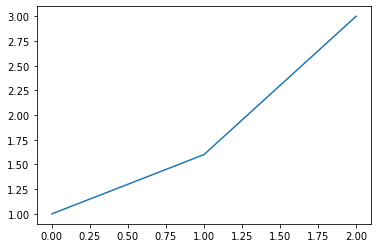

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
# testing pyplot because sometime it gives me headaches
plt.plot([1,1.6,3])

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt


def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Let's look at a couple of images from the dataset. As you can tell, the 32x32px images are quite difficult to identify, even for the human eye. Try changing the indices below to view different images.

Label:  airplane (0)


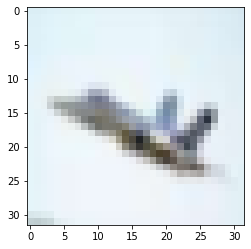

In [22]:
show_example(*dataset[0])

Label:  airplane (0)


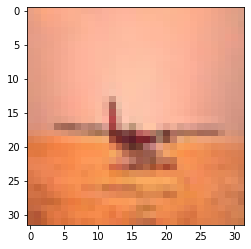

In [23]:
show_example(*dataset[1099])

Before continuing, let's save our work using the `jovian` python library. 

In [24]:
#!pip install jovian --upgrade -q

In [25]:
import jovian

<IPython.core.display.Javascript object>

In [28]:
print(os.getcwd())

d:\Repos\PhD\2020_jovian_deep_learning\05-cifar10-cnn-v-1


In [27]:
#jovian.commit(project=project_name)
jovian.commit(message="Notebook week 4 - first part of CNN", filename="05-cifar10-cnn", project="leosf/" + project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "leosf/05-cifar10-cnn" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/leosf/05-cifar10-cnn


'https://jovian.ml/leosf/05-cifar10-cnn'

`jovian.commit` uploads the notebook to your [Jovian.ml](https://www.jovian.ml) account and creates a sharable link for your notebook as shown above. You can use this link to share your work and let anyone run it online or reproduce it with the `jovian clone` command. 

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [29]:
random_seed = 42
torch.manual_seed(random_seed)

In [30]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

The `jovian` library also provides a simple API for recording important parameters related to the dataset, model training, results etc. for easy reference and comparison between multiple experiments. Let's record `dataset_url`, `val_pct` and `rand_seed` using `jovian.log_dataset`.

In [31]:
jovian.log_dataset(dataset_url=dataset_url, val_size=val_size, random_seed=random_seed)

[jovian] Dataset logged.


We can now create data loaders for training and validation, to load the data in batches

In [32]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [33]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

We can look at batches of images from the dataset using the `make_grid` method from `torchvision`. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [34]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

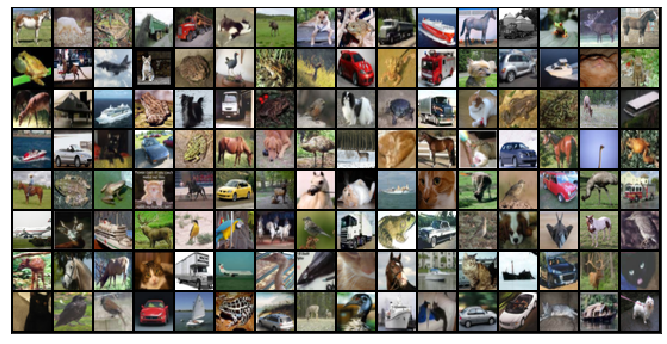

In [35]:
show_batch(train_dl)

Once again, let's save and commit our work using `jovian` before proceeding further.

In [36]:
print(os.getcwd())

d:\Repos\PhD\2020_jovian_deep_learning\05-cifar10-cnn-v-1


In [37]:
#jovian.commit(project=project_name, environment=None)
jovian.commit(message="Notebook week 4", filename="05-cifar10-cnn", project="leosf/" + project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "leosf/05-cifar10-cnn" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/leosf/05-cifar10-cnn


'https://jovian.ml/leosf/05-cifar10-cnn'

After the first commit, all subsequent commits record a new version of the notebook within the same Jovian project. You can use `jovian.commit` to version Jupyter notebooks (instead of doing `File > Save As`), and keep your data science projects organized. Also check out the [**Records**](https://jovian.ml/aakashns/05-cifar10-cnn/v/2/records) tab on the project page to see how the information logged using `jovian.log_dataset` appears on the UI.

<a href="https://jovian.ml/aakashns/05-cifar10-cnn/v/2/records"><img src="https://i.imgur.com/h0zkmn9.png" style="width:400px" ></a>

## Defining the Model (Convolutional Neural Network)

In our [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn), we defined a deep neural network with fully-connected layers using `nn.Linear`. For this tutorial however, we will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch.

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

In [38]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [39]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.

In [57]:
import torch.nn as nn
import torch.nn.functional as F
#import torch.flatten as flatten

In [41]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

Refer to [Sylvian's post](https://sgugger.github.io/convolution-in-depth.html) for an explanation of `kernel_size`, `stride` and `padding`.    

In [42]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


The `Conv2d` layer transforms a 3-channel image to a 16-channel *feature map*, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers, until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get vector of size 10 for each image.

<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [43]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

To use flatten with pythorch v1.1.0 i hadto made some arrangements due to be using cuda 9

In [61]:
from collections import OrderedDict

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [64]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            # nn.Flatten(),  # for Torch version 1.5
            # torch.flatten(),   # for Torch version 1.1.0 needs the tensor to flatten
            Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [65]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features

Let's verify that the model produces the expected output on a batch of training data. The 10 outputs for each image can be interpreted as probabilities for the 10 target classes (after applying softmax), and the class with the highest probability is chosen as the label predicted by the model for the input image. Check out [Part 3 (logistic regression)](https://jovian.ml/aakashns/03-logistic-regression#C50) for a more detailed discussion on interpeting the outputs, applying softmax and identifying the predicted labels.

In [66]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0120,  0.0329, -0.0117, -0.0131, -0.0133, -0.0180,  0.0291,  0.0319,
        -0.0284,  0.0016], grad_fn=<SelectBackward>)


To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [67]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [68]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [71]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features

In [72]:
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features

Once again, let's save and commit the notebook before we proceed further.

In [75]:
project_name

'05-cifar10-cnn'

In [77]:
#jovian.commit(project="leosf/" + project_name)
jovian.commit(message="Notebook week 4 - model definition", filename="05-cifar10-cnn", project="leosf/" + project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "leosf/05-cifar10-cnn" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/leosf/05-cifar10-cnn


'https://jovian.ml/leosf/05-cifar10-cnn'

## Training the Model

We can use the exact same `fit` and `evaluate` functions as defined in the previous tutorials.

In [78]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [80]:
model = to_device(Cifar10CnnModel(), device)

In [81]:
evaluate(model, val_dl)

{'val_loss': 2.302952527999878, 'val_acc': 0.0963350161910057}

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, you can try changing these to see if you have achieve a higher accuracy in a shorter time. 

In [82]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

It's important to record the hyperparameters of every experiment you do, to replicate it later and compare it against other experiments. We can record them using `jovian.log_hyperparams`.

In [83]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [84]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7202, val_loss: 1.3944, val_acc: 0.4930
Epoch [1], train_loss: 1.2315, val_loss: 1.0946, val_acc: 0.5981
Epoch [2], train_loss: 0.9535, val_loss: 0.9087, val_acc: 0.6810
Epoch [3], train_loss: 0.7691, val_loss: 0.8377, val_acc: 0.7117
Epoch [4], train_loss: 0.6323, val_loss: 0.7479, val_acc: 0.7416
Epoch [5], train_loss: 0.5073, val_loss: 0.8721, val_acc: 0.7189
Epoch [6], train_loss: 0.3991, val_loss: 0.8069, val_acc: 0.7466
Epoch [7], train_loss: 0.3046, val_loss: 0.8981, val_acc: 0.7543
Epoch [8], train_loss: 0.2218, val_loss: 0.9147, val_acc: 0.7506
Epoch [9], train_loss: 0.1743, val_loss: 1.1420, val_acc: 0.7428


Just as we have recorded the hyperparameters, we can also record the final metrics achieved by the model using `jovian.log_metrics` for reference, analysis and comparison.

In [85]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


We can also plot the valdation set accuracies to study how the model improves over time.

In [86]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

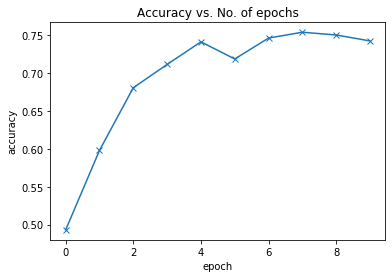

In [87]:
plot_accuracies(history)

Our model reaches an accuracy of around 75%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than 80% even after training for a long time. This suggests that we might need to use a more powerful model to capture the relationship between the images and the labels more accurately. This can be done by adding more convolutional layers to our model, or incrasing the no. of channels in each convolutional layer, or by using regularization techniques.

We can also plot the training and validation losses to study the trend.

In [88]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

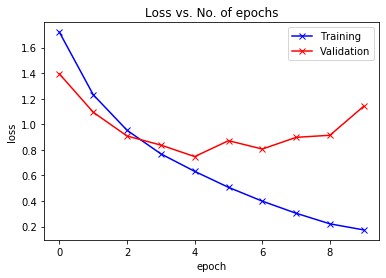

In [89]:
plot_losses(history)

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point! 

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.


Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase

We will cover these topics in more detail in the next tutorial in this series, and learn how we can reach an accuracy of **over 90%** by making minor but important changes to our model.

Before continuing, let us save our work to the cloud using `jovian.commit`.

In [90]:
print(os.getcwd())

d:\Repos\PhD\2020_jovian_deep_learning\05-cifar10-cnn-v-1


In [91]:
#jovian.commit(project=project_name)
jovian.commit(message="Notebook week 4 - iter n. 1 for model training", filename="05-cifar10-cnn", project="leosf/" + project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Error: Failed to detect notebook filename. Please provide the correct notebook filename as the "filename" argument to "jovian.commit".


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "leosf/05-cifar10-cnn" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/leosf/05-cifar10-cnn


'https://jovian.ml/leosf/05-cifar10-cnn'

When you try different experiments (by chaging the learning rate, batch size, optimizer etc.) and record hyperparameters and metrics with each version of your notebook, you can use the [**Compare**](https://jovian.ml/aakashns/05-cifar10-cnn/compare) view on the project page to analyze which approaches are working well and which ones aren't. You sort/filter by accuracy, loss etc., add notes for each version and even invite collaborators to contribute to your project with their own experiments.

<a href="https://jovian.ml/aakashns/05-cifar10-cnn"><img src="https://i.imgur.com/p1Z3vgN.png"></a>

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by creating a test dataset using the `ImageFolder` class.



In [92]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [93]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


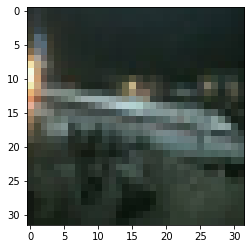

In [94]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


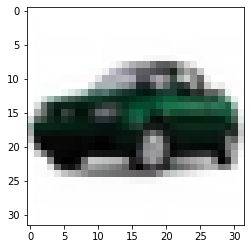

In [95]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


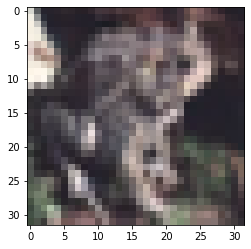

In [96]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set, and record using `jovian`. We expect these values to be similar to those for the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

In [97]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.1539291143417358, 'val_acc': 0.741992175579071}

In [98]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights of the model to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [99]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model. To load the model weights, we can redefine the model with the same structure, and use the `.load_state_dict` method.

In [100]:
model2 = to_device(Cifar10CnnModel(), device)

In [101]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Just as a sanity check, let's verify that this model has the same loss and accuracy on the test set as before.

In [102]:
evaluate(model2, test_loader)

{'val_loss': 1.1539291143417358, 'val_acc': 0.741992175579071}

Let's make one final commit using `jovian`.

In [103]:
#jovian.commit(project=project_name)
jovian.commit(message="Notebook week 4 - notebook complete", filename="05-cifar10-cnn", project="leosf/" + project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "leosf/05-cifar10-cnn" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/leosf/05-cifar10-cnn


'https://jovian.ml/leosf/05-cifar10-cnn'

Check out the **Files** tab on the project page to view or download the trained model weights. You can also download all the files together using the *Download Zip* option in the *Clone* dropdown.

Data science work is often fragmented across many different platforms (Git for code, Dropbox/S3 for datasets & artifacts, spreadsheets for hyperparameters, metrics etc.) which can make it difficult to share and reproduce experiments. Jovian.ml solves this by capturing everyting related to a data science project on a single platform, while providing a seamless workflow for capturing, sharing and reproducting your work. To learn what you can do with Jovian.ml, check out the docs: [https://docs.jovian.ml](https://docs.jovian.ml).

## Summary and Further Reading/Exercises

We've covered a lot of ground in this tutorial. Here's quick recap of the topics:
* Introduction to the CIFAR10 dataset for image classification
* Downloading, extracing and loading an image dataset using `torchvision`
* Show random batches of images in a grid using `torchvision.utils.make_grid`
* Creating a convolutional neural network using with `nn.Conv2d` and `nn.MaxPool2d` layers
* Capturing dataset information, metrics and hyperparameters using the `jovian` library
* Training a convolutional neural network and visualizing the losses and errors
* Understanding overfitting and the strategies for avoiding it (more on this later)
* Generating predictions on single images from the test set
* Saving and loading the model weights, and attaching them to the eperiment snaptshot using `jovian`

There's a lot of scope to experiment here, and I encourage you to use the interactive nature of Jupyter to play around with the various parameters. Here are a few ideas:
* Try chaging the hyperparameters to achieve a higher accuracy within fewer epochs. You use the comparison table on the Jovian.ml project page to compare your experiments.
* Try adding more convolutional layers, or increasing the number of channels in each convolutional layer
* Try using a feedforward neural network and see what's the maximum accuracy you can achieve
* Read about some of the startegies mentioned above for reducing overfitting and achieving better results, and try to implement them by looking into the PyTorch docs.
* Modify this notebook to train a model for a different dataset (e.g. CIFAR100 or ImageNet)

In the next tutorial, we will continue to improve our model's accuracy using techniques like data augmentation, batch normalization and dropout. We will also learn about residual networks (or ResNets), a small but critical change to the model architecture that will significantly boost the performance of our model. Stay tuned!